# Checking differences in chlorophyll every 20 years. 

In [2]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
#import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [9]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

# input file

In [8]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [5]:
PAR_inds = sorted(glob.glob('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_2ndcycle_1990-2009_clim/regrid/regrid_GNG595_clim_1990-2009_PAR_avg.*.nc', recursive=True))
PAR_ds = xr.open_mfdataset(PAR_inds,combine='by_coords')

In [22]:
### First 20 year climatology GNG595
file = '/glade/u/home/gabyn/scratch/SPECTRA/GNG595_2ndcycle_1990-2009_clim'
newNCDFfiles1 = sorted(glob.glob(f'{file}/GNG595_clim_1990-2009_*.nc', recursive=True),
                      key=numericalSort)

ds_01 = xr.open_mfdataset(newNCDFfiles1,concat_dim='time', combine='nested')

In [24]:
chla_01 = np.nansum(np.stack([ds_01.ppChl, ds_01.mp1Chl, ds_01.diazChl, ds_01.diat1Chl, ds_01.mp2Chl, ds_01.diat2Chl, ds_01.mp3Chl, ds_01.diat3Chl, ds_01.mp4Chl]), axis =0)
chla_01[chla_01<=0]=np.nan

chla_01 = np.nansum(np.stack([ds_01.ppChl, ds_01.mp1Chl, ds_01.diazChl, ds_01.diat1Chl, ds_01.mp2Chl, ds_01.diat2Chl, ds_01.mp3Chl, ds_01.diat3Chl, ds_01.mp4Chl]), axis =0)
chla_01[chla_01<=0]=np.nan

chla_02 = np.nansum(np.stack([ds_02.ppChl, ds_02.mp1Chl, ds_02.diazChl, ds_02.diat1Chl, ds_02.mp2Chl, ds_02.diat2Chl, ds_02.mp3Chl, ds_02.diat3Chl, ds_02.mp4Chl]), axis =0)
chla_02[chla_02<=0]=np.nan

chla_03 = np.nansum(np.stack([ds_03.ppChl, ds_03.mp1Chl, ds_03.diazChl, ds_03.diat1Chl, ds_03.mp2Chl, ds_03.diat2Chl, ds_03.mp3Chl, ds_03.diat3Chl, ds_03.mp4Chl]), axis =0)
chla_03[chla_03<=0]=np.nan

## Load remapped files

In [25]:
regrid_chl = '/glade/u/home/gabyn/scratch/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_'

diat1_01_inds = sorted(glob.glob(f'{regrid_chl}diat1Chl.*.nc', recursive=True))
diat1_01_ds = xr.open_mfdataset(diat1_01_inds,concat_dim='time', combine='nested')

diat2_01_inds = sorted(glob.glob(f'{regrid_chl}diat2Chl.*.nc', recursive=True))
diat2_01_ds = xr.open_mfdataset(diat2_01_inds,concat_dim='time', combine='nested')

diat3_01_inds = sorted(glob.glob(f'{regrid_chl}diat3Chl.*.nc', recursive=True))
diat3_01_ds = xr.open_mfdataset(diat3_01_inds,concat_dim='time', combine='nested')

mp1_01_inds = sorted(glob.glob(f'{regrid_chl}mp1Chl.*.nc', recursive=True))
mp1_01_ds = xr.open_mfdataset(mp1_01_inds,concat_dim='time', combine='nested')

mp2_01_inds = sorted(glob.glob(f'{regrid_chl}mp2Chl.*.nc', recursive=True))
mp2_01_ds = xr.open_mfdataset(mp2_01_inds,concat_dim='time', combine='nested')

mp3_01_inds = sorted(glob.glob(f'{regrid_chl}mp3Chl.*.nc', recursive=True))
mp3_01_ds = xr.open_mfdataset(mp3_01_inds,concat_dim='time', combine='nested')

mp4_01_inds = sorted(glob.glob(f'{regrid_chl}mp4Chl.*.nc', recursive=True))
mp4_01_ds = xr.open_mfdataset(mp4_01_inds,concat_dim='time', combine='nested')

pp_01_inds = sorted(glob.glob(f'{regrid_chl}ppChl.*.nc', recursive=True))
pp_01_ds = xr.open_mfdataset(pp_01_inds,concat_dim='time', combine='nested')

diaz_01_inds = sorted(glob.glob(f'{regrid_chl}diazChl.*.nc', recursive=True))
diaz_01_ds = xr.open_mfdataset(diaz_01_inds,concat_dim='time', combine='nested')

	NC4_close: ncid 0x10000
			nc4_close_hdf5_file: h5->path /glade/work/jluo/obs/SeaWiFS/climatology_regridded/01_S19980012010031.L3m_MC_CHL_chl_ocx_gx1v6.nc abort 0
			nc4_rec_grp_HDF5_del: grp->name /
			closing HDF5 dataset 360287970189639680
			closing HDF5 dataset 360287970189639681
			closing HDF5 dataset 360287970189639682
			closing HDF5 dataset 360287970189639683
			closing HDF5 dataset 360287970189639687
			closing HDF5 dataset 360287970189639690
			nc4_close_netcdf4_file: h5->path /glade/work/jluo/obs/SeaWiFS/climatology_regridded/01_S19980012010031.L3m_MC_CHL_chl_ocx_gx1v6.nc abort 0
			nc4_rec_grp_del: grp->name /
			att_free: name _FillValue 
			att_free: name units 
			att_free: name long_name 
			att_free: name comments 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name units 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name units 
	NC4_close: ncid 0x20000
			nc4_close_hdf5_file: h5->path /glade/work/jluo/obs/SeaWiFS/

In [26]:
phytoChl_01 = np.stack([pp_01_ds.ppChl, mp1_01_ds.mp1Chl, diaz_01_ds.diazChl, 
                               diat1_01_ds.diat1Chl, mp2_01_ds.mp2Chl, diat2_01_ds.diat2Chl, 
                               mp3_01_ds.mp3Chl, diat3_01_ds.diat3Chl, mp4_01_ds.mp4Chl])
phytoChl_01_surface = np.nansum(phytoChl_01[:,:,0,:,:], axis =0) 

In [27]:
obsfiles = sorted(glob.glob('/glade/work/jluo/obs/SeaWiFS/climatology_regridded/'+'*L3m_MC_CHL_chl_ocx_gx1v6.nc', recursive=True),
                      key=numericalSort)
obs = xr.open_mfdataset(obsfiles,combine='by_coords')

	NC4_open: path /glade/work/jluo/obs/SeaWiFS/climatology_regridded/01_S19980012010031.L3m_MC_CHL_chl_ocx_gx1v6.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/work/jluo/obs/SeaWiFS/climatology_regridded/01_S19980012010031.L3m_MC_CHL_chl_ocx_gx1v6.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset nlat
			found dataset nlon
			found dataset time
			found dataset chl_ocx
			found dataset TLONG
			found dataset TLAT
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0x130000 ext_ncid 0x130000
		FILE - path: /glade/work/jluo/obs/SeaWiFS/climatology_regridded/01_S19980012010031.L3m_MC_CHL_chl_ocx_gx1v6.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 6 natts: 0
		 DIMENSION - dimid: 0 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 1 name: nlon len: 320 unlimited: 0
		 DIMENSION - dimid: 2 name: time len: 1

In [28]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [29]:
chla_01 = np.nansum(np.stack([ds_01.ppChl, ds_01.mp1Chl, ds_01.diazChl, ds_01.diat1Chl, ds_01.mp2Chl, ds_01.diat2Chl, ds_01.mp3Chl, ds_01.diat3Chl, ds_01.mp4Chl]), axis =0)
chla_01[chla_01<=0]=np.nan

		NC4_inq_var_all: ncid 0x130000 varid 3
		NC4_inq_var_all: ncid 0x130000 varid 3
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_var_all: ncid 0x130000 varid 3
		NC4_inq_var_all: ncid 0x130000 varid 3
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_var_all: ncid 0x130000 varid 3
		NC4_inq_var_all: ncid 0x130000 varid 3
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_var_all: ncid 0x130000 varid 3
			NC4_get_vars: var->hdr.name chl_ocx mem_nc_type 5
		NC4_inq_var_all: ncid 0x130000 varid 3
		NC4_inq_var_all: ncid 0x130000 varid 3
		NC4_inq_dim: ncid 0x130000 dimid 2
		NC4_inq_dim: ncid 0x130000 dimid 0
		NC4_inq_dim: ncid 0x130000 dimid 1
		NC4_inq_att: ncid 0x1

{60: ([<matplotlib.lines.Line2D at 0x2ae9304fef10>,
  []),
 90: ([<matplotlib.lines.Line2D at 0x2ae9304fee90>], []),
 80.0: ([<matplotlib.lines.Line2D at 0x2ae93050ed90>], [])}

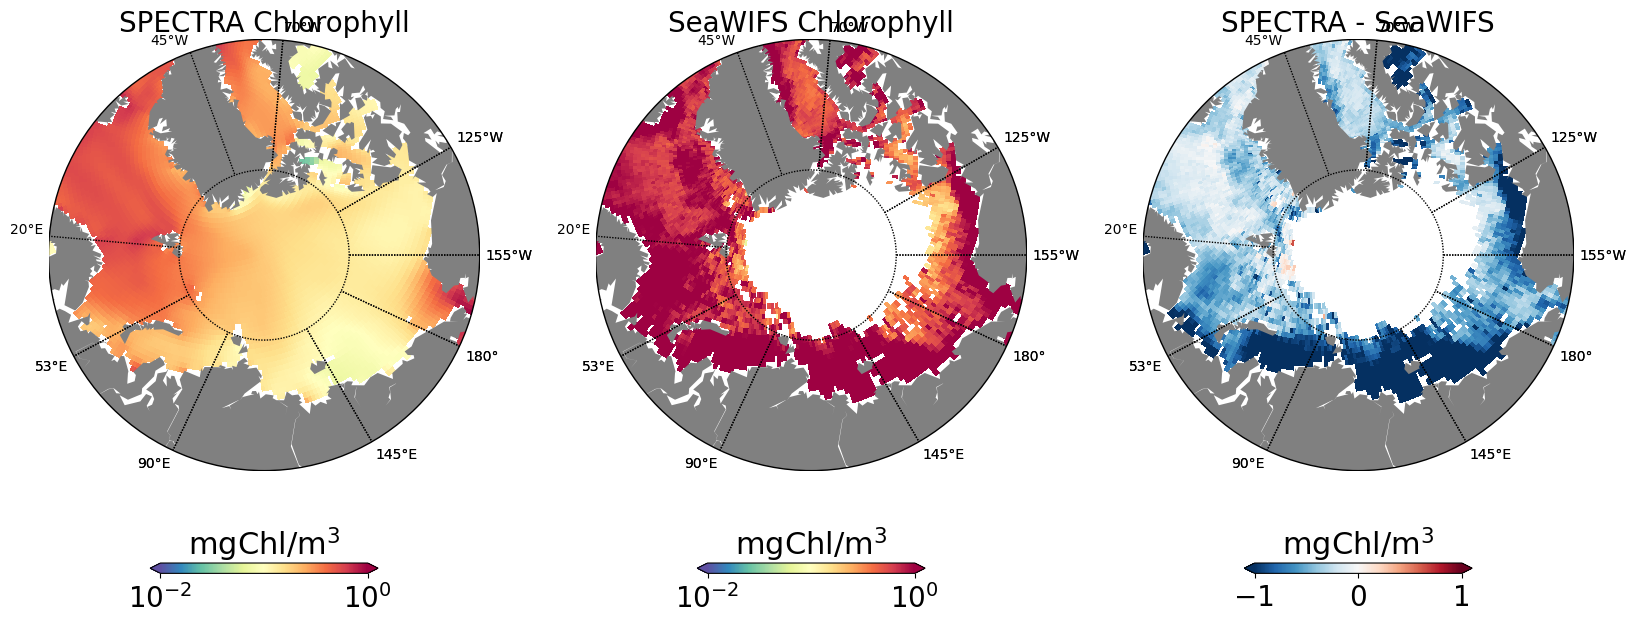

In [30]:
fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chl = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(chla_01[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl,cmap='Spectral_r', norm=colors.LogNorm(vmin=0.01, vmax=1))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SPECTRA Chlorophyll', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chlo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(obs.chl_ocx[:,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chlo,cmap='Spectral_r', norm=colors.LogNorm(vmin=0.01, vmax=1))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SeaWIFS Chlorophyll', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,(np.log10(chl)-np.log10(chlo)),cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SPECTRA - SeaWIFS', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chla_AO_annual_comparison_1st20years.png',dpi=600, bbox_inches='tight')

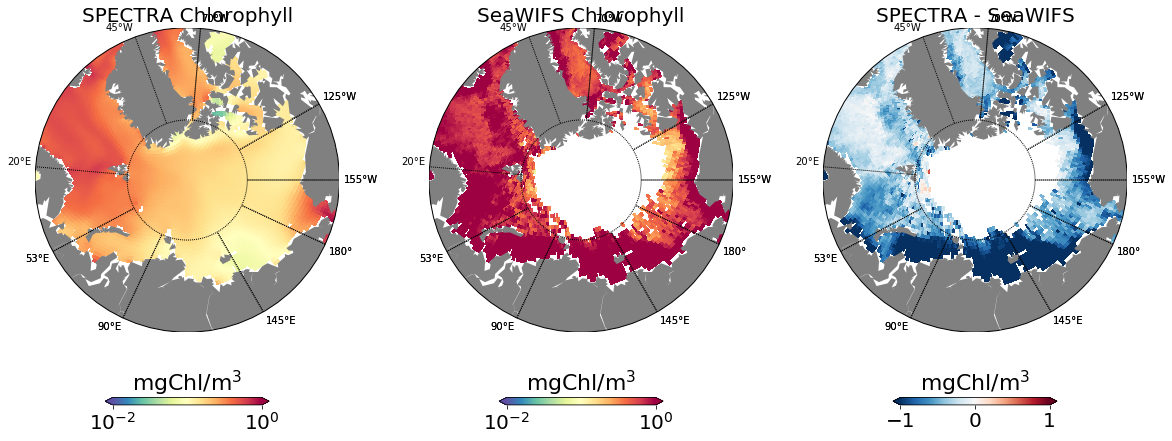

In [18]:
fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chl = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(chla_02[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl,cmap='Spectral_r', norm=colors.LogNorm(vmin=0.01, vmax=1))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SPECTRA Chlorophyll', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chlo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(obs.chl_ocx[:,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chlo,cmap='Spectral_r', norm=colors.LogNorm(vmin=0.01, vmax=1))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SeaWIFS Chlorophyll', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,(np.log10(chl)-np.log10(chlo)),cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SPECTRA - SeaWIFS', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chla_AO_annual_comparison_2nd20years.png',dpi=600, bbox_inches='tight')

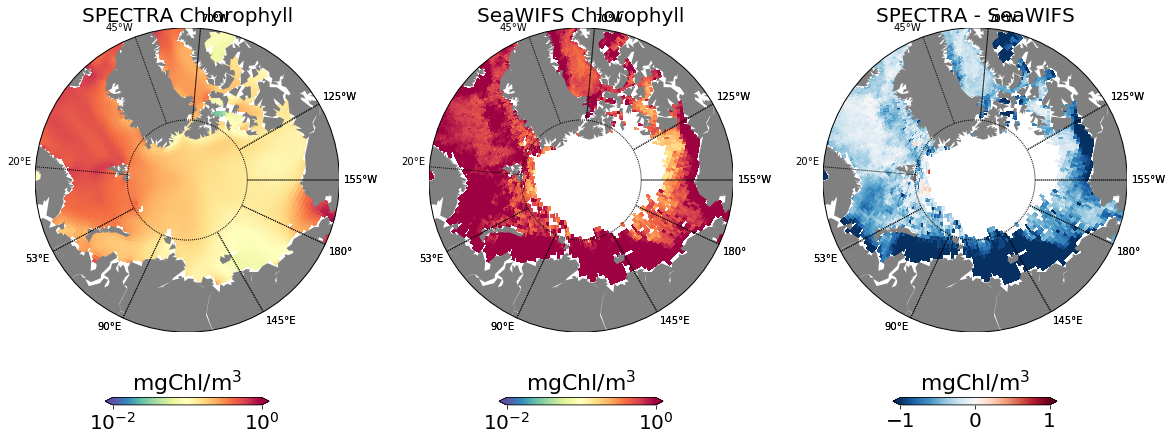

In [19]:
fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chl = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(chla_03[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl,cmap='Spectral_r', norm=colors.LogNorm(vmin=0.01, vmax=1))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SPECTRA Chlorophyll', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chlo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(obs.chl_ocx[:,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chlo,cmap='Spectral_r', norm=colors.LogNorm(vmin=0.01, vmax=1))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SeaWIFS Chlorophyll', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,(np.log10(chl)-np.log10(chlo)),cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SPECTRA - SeaWIFS', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chla_AO_annual_comparison_3th20years.png',dpi=600, bbox_inches='tight')

## Now let's Create one with the frist 20 year climatology, the second and the third in a row! 

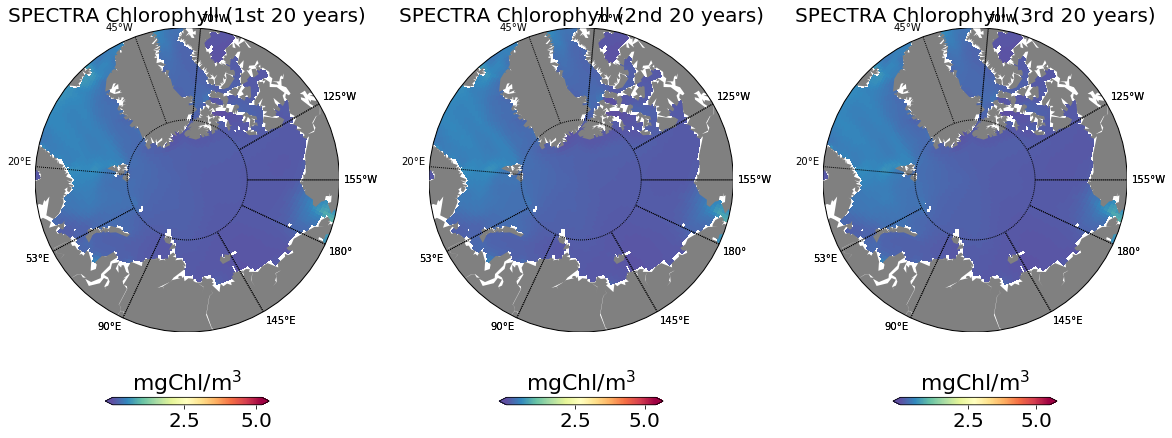

In [20]:
fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chl1 = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(chla_01[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl1,cmap='Spectral_r')
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SPECTRA Chlorophyll (1st 20 years)', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chl2 = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(chla_02[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl2,cmap='Spectral_r')
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SPECTRA Chlorophyll (2nd 20 years)', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chl3 = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(chla_03[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl3,cmap='Spectral_r')
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SPECTRA Chlorophyll (3rd 20 years)', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chla_AO_annual_comparison_20year_climatologies.png',dpi=600, bbox_inches='tight')

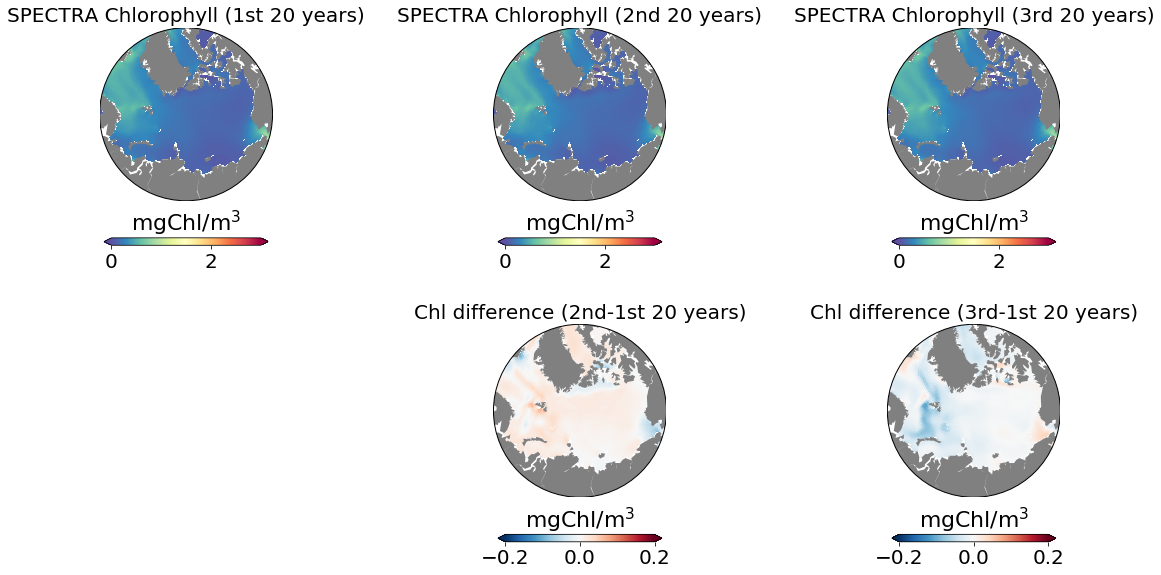

In [21]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(2, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chl1 = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(chla_01[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl1,cmap='Spectral_r',vmin=0,vmax=3)
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SPECTRA Chlorophyll (1st 20 years)', fontsize =20)

ax = fig.add_subplot(2, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chl2 = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(chla_02[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl2,cmap='Spectral_r',vmin=0,vmax=3)
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SPECTRA Chlorophyll (2nd 20 years)', fontsize =20)

ax = fig.add_subplot(2, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chl3 = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(chla_03[:,0,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl3,cmap='Spectral_r',vmin=0,vmax=3)
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('SPECTRA Chlorophyll (3rd 20 years)', fontsize =20)

ax = fig.add_subplot(2, 3, 5)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,chl2-chl1,cmap='RdBu_r',vmin=-0.2,vmax=0.2)
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('Chl difference (2nd-1st 20 years)', fontsize =20)

ax = fig.add_subplot(2, 3, 6)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,chl1-chl3,cmap='RdBu_r',vmin=-0.2,vmax=0.2)
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('Chl difference (3rd-1st 20 years)', fontsize =20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chla_AO_annual_comparison_20year_diff_climatologies.png',dpi=600, bbox_inches='tight')

## Now try to create a climatology of the Arctic Ocean, with the Seaseaonl Sea-Ice to see if the phytoplankton blooms have changes at all through the decades

In [18]:
obsfiles_regrid = sorted(glob.glob('/glade/scratch/gabyn/SeaWiFS/regrid_chl_ocx_SeaWiFS.*.nc', recursive=True),
                      key=numericalSort)
obss = xr.open_mfdataset(obsfiles_regrid,concat_dim='time',combine='nested')

In [19]:
PAR_01_ds.PAR_avg.shape

(12, 15, 180, 360)

In [20]:
# Model ice for every region 
ice_ao_01 = np.nanmean(ICE_01_ds.ECOSYS_IFRAC[:,170:180,:], axis=(1,2))
ice_cs_01 = np.nanmean(ICE_01_ds.ECOSYS_IFRAC[:,149:170,0:25], axis = (1,2))
ice_bs_01 = np.nanmean(ICE_01_ds.ECOSYS_IFRAC[:,149:170,25:55], axis = (1,2))
ice_ca_01 = np.nanmean(ICE_01_ds.ECOSYS_IFRAC[:,149:170,55:110], axis = (1,2))
ice_bb_01 = np.nanmean(ICE_01_ds.ECOSYS_IFRAC[:,149:170,110:135], axis = (1,2))
ice_ess_01 = np.nanmean(ICE_01_ds.ECOSYS_IFRAC[:,149:170,325:360], axis = (1,2))
ice_ls_01 = np.nanmean(ICE_01_ds.ECOSYS_IFRAC[:,149:170,270:325], axis = (1,2))
ice_ns_01 = np.nanmean(ICE_01_ds.ECOSYS_IFRAC[:,149:170,155:205], axis = (1,2))
ice_bts_01 =np.nanmean(ICE_01_ds.ECOSYS_IFRAC[:,149:170,205:233], axis = (1,2))
ice_ks_01 = np.nanmean(ICE_01_ds.ECOSYS_IFRAC[:,149:170,233:270], axis = (1,2))


## Temperature 
temp_ao_01 = np.nanmean(temp_01_ds.TEMP[:,0,170:180,:], axis=(1,2))
temp_cs_01 = np.nanmean(temp_01_ds.TEMP[:,0,149:170,0:25], axis = (1,2))
temp_bs_01 = np.nanmean(temp_01_ds.TEMP[:,0,149:170,25:55], axis = (1,2))
temp_ca_01 = np.nanmean(temp_01_ds.TEMP[:,0,149:170,55:110], axis = (1,2))
temp_bb_01 = np.nanmean(temp_01_ds.TEMP[:,0,149:170,110:135], axis = (1,2))
temp_ess_01 = np.nanmean(temp_01_ds.TEMP[:,0,149:170,325:360], axis = (1,2))
temp_ls_01 = np.nanmean(temp_01_ds.TEMP[:,0,149:170,270:325], axis = (1,2))
temp_ns_01 = np.nanmean(temp_01_ds.TEMP[:,0,149:170,155:205], axis = (1,2))
temp_bts_01 =np.nanmean(temp_01_ds.TEMP[:,0,149:170,205:233], axis = (1,2))
temp_ks_01 = np.nanmean(temp_01_ds.TEMP[:,0,149:170,233:270], axis = (1,2))

# Modeling the PAR average 
PAR_ao_01 = np.nanmean(PAR_01_ds.PAR_avg[:,0,170:180,:], axis=(1,2))
PAR_cs_01 = np.nanmean(PAR_01_ds.PAR_avg[:,0,149:170,0:25], axis = (1,2))
PAR_bs_01 = np.nanmean(PAR_01_ds.PAR_avg[:,0,149:170,25:55], axis = (1,2))
PAR_ca_01 = np.nanmean(PAR_01_ds.PAR_avg[:,0,149:170,55:110], axis = (1,2))
PAR_bb_01 = np.nanmean(PAR_01_ds.PAR_avg[:,0,149:170,110:135], axis = (1,2))
PAR_ess_01 = np.nanmean(PAR_01_ds.PAR_avg[:,0,149:170,325:360], axis = (1,2))
PAR_ls_01 = np.nanmean(PAR_01_ds.PAR_avg[:,0,149:170,270:325], axis = (1,2))
PAR_ns_01 = np.nanmean(PAR_01_ds.PAR_avg[:,0,149:170,155:205], axis = (1,2))
PAR_bts_01 =np.nanmean(PAR_01_ds.PAR_avg[:,0,149:170,205:233], axis = (1,2))
PAR_ks_01 = np.nanmean(PAR_01_ds.PAR_avg[:,0,149:170,233:270], axis = (1,2))

# Modeling the PAR average 
PAR5_ao_01 = np.nanmean(PAR_01_ds.PAR_avg[:,1,170:180,:], axis=(1,2))
PAR5_cs_01 = np.nanmean(PAR_01_ds.PAR_avg[:,1,149:170,0:25], axis = (1,2))
PAR5_bs_01 = np.nanmean(PAR_01_ds.PAR_avg[:,1,149:170,25:55], axis = (1,2))
PAR5_ca_01 = np.nanmean(PAR_01_ds.PAR_avg[:,1,149:170,55:110], axis = (1,2))
PAR5_bb_01 = np.nanmean(PAR_01_ds.PAR_avg[:,1,149:170,110:135], axis = (1,2))
PAR5_ess_01 = np.nanmean(PAR_01_ds.PAR_avg[:,1,149:170,325:360], axis = (1,2))
PAR5_ls_01 = np.nanmean(PAR_01_ds.PAR_avg[:,1,149:170,270:325], axis = (1,2))
PAR5_ns_01 = np.nanmean(PAR_01_ds.PAR_avg[:,1,149:170,155:205], axis = (1,2))
PAR5_bts_01 =np.nanmean(PAR_01_ds.PAR_avg[:,1,149:170,205:233], axis = (1,2))
PAR5_ks_01 = np.nanmean(PAR_01_ds.PAR_avg[:,1,149:170,233:270], axis = (1,2))

# Model Chlorophyll for every region (surface)
model_ao_01 = np.nanmean(phytoChl_01_surface[:,170:180,:], axis=(1,2))
model_cs_01 = np.nanmean(phytoChl_01_surface[:,149:170,0:25], axis = (1,2))
model_bs_01 = np.nanmean(phytoChl_01_surface[:,149:170,25:55], axis = (1,2))
model_ca_01 = np.nanmean(phytoChl_01_surface[:,149:170,55:110], axis = (1,2))
model_bb_01 = np.nanmean(phytoChl_01_surface[:,149:170,110:135], axis = (1,2))
model_ess_01 = np.nanmean(phytoChl_01_surface[:,149:170,325:360], axis = (1,2))
model_ls_01 = np.nanmean(phytoChl_01_surface[:,149:170,270:325], axis = (1,2))
model_ns_01 = np.nanmean(phytoChl_01_surface[:,149:170,155:205], axis = (1,2))
model_bts_01 =np.nanmean(phytoChl_01_surface[:,149:170,205:233], axis = (1,2))
model_ks_01 = np.nanmean(phytoChl_01_surface[:,149:170,233:270], axis = (1,2))

# Top 50 meters
model_ao_50m_01 = np.nanmean(phytoChl_01_50m[:,170:180,:], axis=(1,2))
model_cs_50m_01 = np.nanmean(phytoChl_01_50m[:,149:170,0:25], axis = (1,2))
model_bs_50m_01 = np.nanmean(phytoChl_01_50m[:,149:170,25:55], axis = (1,2))
model_ca_50m_01 = np.nanmean(phytoChl_01_50m[:,149:170,55:110], axis = (1,2))
model_bb_50m_01 = np.nanmean(phytoChl_01_50m[:,149:170,110:135], axis = (1,2))
model_ess_50m_01 = np.nanmean(phytoChl_01_50m[:,149:170,325:360], axis = (1,2))
model_ls_50m_01 = np.nanmean(phytoChl_01_50m[:,149:170,270:325], axis = (1,2))
model_ns_50m_01 = np.nanmean(phytoChl_01_50m[:,149:170,155:205], axis = (1,2))
model_bts_50m_01 =np.nanmean(phytoChl_01_50m[:,149:170,205:233], axis = (1,2))
model_ks_50m_01 = np.nanmean(phytoChl_01_50m[:,149:170,233:270], axis = (1,2))

# Observed Chlorophyll for every region. 
obs_ao = np.nanmean(obss.chl_ocx[:,170:180,:], axis=(1,2))
obs_cs = np.nanmean(obss.chl_ocx[:,149:170,0:25], axis = (1,2))
obs_bs = np.nanmean(obss.chl_ocx[:,149:170,25:55], axis = (1,2))
obs_ca = np.nanmean(obss.chl_ocx[:,149:170,55:110], axis = (1,2))
obs_bb = np.nanmean(obss.chl_ocx[:,149:170,110:135], axis = (1,2))
obs_ess = np.nanmean(obss.chl_ocx[:,149:170,325:360], axis = (1,2))
obs_ls = np.nanmean(obss.chl_ocx[:,149:170,270:325], axis = (1,2))
obs_ns = np.nanmean(obss.chl_ocx[:,149:170,155:205], axis = (1,2))
obs_bts =np.nanmean(obss.chl_ocx[:,149:170,205:233], axis = (1,2))
obs_ks = np.nanmean(obss.chl_ocx[:,149:170,233:270], axis = (1,2))

In [21]:
# Model ice for every region 
ice_ao_02 = np.nanmean(ICE_02_ds.ECOSYS_IFRAC[:,170:180,:], axis=(1,2))
ice_cs_02 = np.nanmean(ICE_02_ds.ECOSYS_IFRAC[:,149:170,0:25], axis = (1,2))
ice_bs_02 = np.nanmean(ICE_02_ds.ECOSYS_IFRAC[:,149:170,25:55], axis = (1,2))
ice_ca_02 = np.nanmean(ICE_02_ds.ECOSYS_IFRAC[:,149:170,55:110], axis = (1,2))
ice_bb_02 = np.nanmean(ICE_02_ds.ECOSYS_IFRAC[:,149:170,110:135], axis = (1,2))
ice_ess_02 = np.nanmean(ICE_02_ds.ECOSYS_IFRAC[:,149:170,325:360], axis = (1,2))
ice_ls_02 = np.nanmean(ICE_02_ds.ECOSYS_IFRAC[:,149:170,270:325], axis = (1,2))
ice_ns_02 = np.nanmean(ICE_02_ds.ECOSYS_IFRAC[:,149:170,155:205], axis = (1,2))
ice_bts_02 =np.nanmean(ICE_02_ds.ECOSYS_IFRAC[:,149:170,205:233], axis = (1,2))
ice_ks_02 = np.nanmean(ICE_02_ds.ECOSYS_IFRAC[:,149:170,233:270], axis = (1,2))

## Temperature 
temp_ao_02 = np.nanmean(temp_02_ds.TEMP[:,0,170:180,:], axis=(1,2))
temp_cs_02 = np.nanmean(temp_02_ds.TEMP[:,0,149:170,0:25], axis = (1,2))
temp_bs_02 = np.nanmean(temp_02_ds.TEMP[:,0,149:170,25:55], axis = (1,2))
temp_ca_02 = np.nanmean(temp_02_ds.TEMP[:,0,149:170,55:110], axis = (1,2))
temp_bb_02 = np.nanmean(temp_02_ds.TEMP[:,0,149:170,110:135], axis = (1,2))
temp_ess_02 = np.nanmean(temp_02_ds.TEMP[:,0,149:170,325:360], axis = (1,2))
temp_ls_02 = np.nanmean(temp_02_ds.TEMP[:,0,149:170,270:325], axis = (1,2))
temp_ns_02 = np.nanmean(temp_02_ds.TEMP[:,0,149:170,155:205], axis = (1,2))
temp_bts_02 =np.nanmean(temp_02_ds.TEMP[:,0,149:170,205:233], axis = (1,2))
temp_ks_02 = np.nanmean(temp_02_ds.TEMP[:,0,149:170,233:270], axis = (1,2))

# Modeling the PAR average 
PAR_ao_02 = np.nanmean(PAR_02_ds.PAR_avg[:,0,170:180,:], axis=(1,2))
PAR_cs_02 = np.nanmean(PAR_02_ds.PAR_avg[:,0,149:170,0:25], axis = (1,2))
PAR_bs_02 = np.nanmean(PAR_02_ds.PAR_avg[:,0,149:170,25:55], axis = (1,2))
PAR_ca_02 = np.nanmean(PAR_02_ds.PAR_avg[:,0,149:170,55:110], axis = (1,2))
PAR_bb_02 = np.nanmean(PAR_02_ds.PAR_avg[:,0,149:170,110:135], axis = (1,2))
PAR_ess_02 = np.nanmean(PAR_02_ds.PAR_avg[:,0,149:170,325:360], axis = (1,2))
PAR_ls_02 = np.nanmean(PAR_02_ds.PAR_avg[:,0,149:170,270:325], axis = (1,2))
PAR_ns_02 = np.nanmean(PAR_02_ds.PAR_avg[:,0,149:170,155:205], axis = (1,2))
PAR_bts_02 =np.nanmean(PAR_02_ds.PAR_avg[:,0,149:170,205:233], axis = (1,2))
PAR_ks_02 = np.nanmean(PAR_02_ds.PAR_avg[:,0,149:170,233:270], axis = (1,2))

# Modeling the PAR average 
PAR5_ao_02 = np.nanmean(PAR_02_ds.PAR_avg[:,1,170:180,:], axis=(1,2))
PAR5_cs_02 = np.nanmean(PAR_02_ds.PAR_avg[:,1,149:170,0:25], axis = (1,2))
PAR5_bs_02 = np.nanmean(PAR_02_ds.PAR_avg[:,1,149:170,25:55], axis = (1,2))
PAR5_ca_02 = np.nanmean(PAR_02_ds.PAR_avg[:,1,149:170,55:110], axis = (1,2))
PAR5_bb_02 = np.nanmean(PAR_02_ds.PAR_avg[:,1,149:170,110:135], axis = (1,2))
PAR5_ess_02 = np.nanmean(PAR_02_ds.PAR_avg[:,1,149:170,325:360], axis = (1,2))
PAR5_ls_02 = np.nanmean(PAR_02_ds.PAR_avg[:,1,149:170,270:325], axis = (1,2))
PAR5_ns_02 = np.nanmean(PAR_02_ds.PAR_avg[:,1,149:170,155:205], axis = (1,2))
PAR5_bts_02 =np.nanmean(PAR_02_ds.PAR_avg[:,1,149:170,205:233], axis = (1,2))
PAR5_ks_02 = np.nanmean(PAR_02_ds.PAR_avg[:,1,149:170,233:270], axis = (1,2))

# Model Chlorophyll for every region (surface)
model_ao_02 = np.nanmean(phytoChl_02_surface[:,170:180,:], axis=(1,2))
model_cs_02 = np.nanmean(phytoChl_02_surface[:,149:170,0:25], axis = (1,2))
model_bs_02 = np.nanmean(phytoChl_02_surface[:,149:170,25:55], axis = (1,2))
model_ca_02 = np.nanmean(phytoChl_02_surface[:,149:170,55:110], axis = (1,2))
model_bb_02 = np.nanmean(phytoChl_02_surface[:,149:170,110:135], axis = (1,2))
model_ess_02 = np.nanmean(phytoChl_02_surface[:,149:170,325:360], axis = (1,2))
model_ls_02 = np.nanmean(phytoChl_02_surface[:,149:170,270:325], axis = (1,2))
model_ns_02 = np.nanmean(phytoChl_02_surface[:,149:170,155:205], axis = (1,2))
model_bts_02 =np.nanmean(phytoChl_02_surface[:,149:170,205:233], axis = (1,2))
model_ks_02 = np.nanmean(phytoChl_02_surface[:,149:170,233:270], axis = (1,2))

# Top 50 meters
model_ao_50m_02 = np.nanmean(phytoChl_02_50m[:,170:180,:], axis=(1,2))
model_cs_50m_02 = np.nanmean(phytoChl_02_50m[:,149:170,0:25], axis = (1,2))
model_bs_50m_02 = np.nanmean(phytoChl_02_50m[:,149:170,25:55], axis = (1,2))
model_ca_50m_02 = np.nanmean(phytoChl_02_50m[:,149:170,55:110], axis = (1,2))
model_bb_50m_02 = np.nanmean(phytoChl_02_50m[:,149:170,110:135], axis = (1,2))
model_ess_50m_02 = np.nanmean(phytoChl_02_50m[:,149:170,325:360], axis = (1,2))
model_ls_50m_02 = np.nanmean(phytoChl_02_50m[:,149:170,270:325], axis = (1,2))
model_ns_50m_02 = np.nanmean(phytoChl_02_50m[:,149:170,155:205], axis = (1,2))
model_bts_50m_02 =np.nanmean(phytoChl_02_50m[:,149:170,205:233], axis = (1,2))
model_ks_50m_02 = np.nanmean(phytoChl_02_50m[:,149:170,233:270], axis = (1,2))



In [22]:
# Model ice for every region 
ice_ao_03 = np.nanmean(ICE_03_ds.ECOSYS_IFRAC[:,170:180,:], axis=(1,2))
ice_cs_03 = np.nanmean(ICE_03_ds.ECOSYS_IFRAC[:,149:170,0:25], axis = (1,2))
ice_bs_03 = np.nanmean(ICE_03_ds.ECOSYS_IFRAC[:,149:170,25:55], axis = (1,2))
ice_ca_03 = np.nanmean(ICE_03_ds.ECOSYS_IFRAC[:,149:170,55:110], axis = (1,2))
ice_bb_03 = np.nanmean(ICE_03_ds.ECOSYS_IFRAC[:,149:170,110:135], axis = (1,2))
ice_ess_03 = np.nanmean(ICE_03_ds.ECOSYS_IFRAC[:,149:170,325:360], axis = (1,2))
ice_ls_03 = np.nanmean(ICE_03_ds.ECOSYS_IFRAC[:,149:170,270:325], axis = (1,2))
ice_ns_03 = np.nanmean(ICE_03_ds.ECOSYS_IFRAC[:,149:170,155:205], axis = (1,2))
ice_bts_03 =np.nanmean(ICE_03_ds.ECOSYS_IFRAC[:,149:170,205:233], axis = (1,2))
ice_ks_03 = np.nanmean(ICE_03_ds.ECOSYS_IFRAC[:,149:170,233:270], axis = (1,2))

## Temperature 
temp_ao_03 = np.nanmean(temp_03_ds.TEMP[:,0,170:180,:], axis=(1,2))
temp_cs_03 = np.nanmean(temp_03_ds.TEMP[:,0,149:170,0:25], axis = (1,2))
temp_bs_03 = np.nanmean(temp_03_ds.TEMP[:,0,149:170,25:55], axis = (1,2))
temp_ca_03 = np.nanmean(temp_03_ds.TEMP[:,0,149:170,55:110], axis = (1,2))
temp_bb_03 = np.nanmean(temp_03_ds.TEMP[:,0,149:170,110:135], axis = (1,2))
temp_ess_03 = np.nanmean(temp_03_ds.TEMP[:,0,149:170,325:360], axis = (1,2))
temp_ls_03 = np.nanmean(temp_03_ds.TEMP[:,0,149:170,270:325], axis = (1,2))
temp_ns_03 = np.nanmean(temp_03_ds.TEMP[:,0,149:170,155:205], axis = (1,2))
temp_bts_03 =np.nanmean(temp_03_ds.TEMP[:,0,149:170,205:233], axis = (1,2))
temp_ks_03 = np.nanmean(temp_03_ds.TEMP[:,0,149:170,233:270], axis = (1,2))

# Modeling the PAR average 
PAR_ao_03 = np.nanmean(PAR_03_ds.PAR_avg[:,0,170:180,:], axis=(1,2))
PAR_cs_03 = np.nanmean(PAR_03_ds.PAR_avg[:,0,149:170,0:25], axis = (1,2))
PAR_bs_03 = np.nanmean(PAR_03_ds.PAR_avg[:,0,149:170,25:55], axis = (1,2))
PAR_ca_03 = np.nanmean(PAR_03_ds.PAR_avg[:,0,149:170,55:110], axis = (1,2))
PAR_bb_03 = np.nanmean(PAR_03_ds.PAR_avg[:,0,149:170,110:135], axis = (1,2))
PAR_ess_03 = np.nanmean(PAR_03_ds.PAR_avg[:,0,149:170,325:360], axis = (1,2))
PAR_ls_03 = np.nanmean(PAR_03_ds.PAR_avg[:,0,149:170,270:325], axis = (1,2))
PAR_ns_03 = np.nanmean(PAR_03_ds.PAR_avg[:,0,149:170,155:205], axis = (1,2))
PAR_bts_03 =np.nanmean(PAR_03_ds.PAR_avg[:,0,149:170,205:233], axis = (1,2))
PAR_ks_03 = np.nanmean(PAR_03_ds.PAR_avg[:,0,149:170,233:270], axis = (1,2))

# Modeling the PAR average 
PAR5_ao_03 = np.nanmean(PAR_03_ds.PAR_avg[:,1,170:180,:], axis=(1,2))
PAR5_cs_03 = np.nanmean(PAR_03_ds.PAR_avg[:,1,149:170,0:25], axis = (1,2))
PAR5_bs_03 = np.nanmean(PAR_03_ds.PAR_avg[:,1,149:170,25:55], axis = (1,2))
PAR5_ca_03 = np.nanmean(PAR_03_ds.PAR_avg[:,1,149:170,55:110], axis = (1,2))
PAR5_bb_03 = np.nanmean(PAR_03_ds.PAR_avg[:,1,149:170,110:135], axis = (1,2))
PAR5_ess_03 = np.nanmean(PAR_03_ds.PAR_avg[:,1,149:170,325:360], axis = (1,2))
PAR5_ls_03 = np.nanmean(PAR_03_ds.PAR_avg[:,1,149:170,270:325], axis = (1,2))
PAR5_ns_03 = np.nanmean(PAR_03_ds.PAR_avg[:,1,149:170,155:205], axis = (1,2))
PAR5_bts_03 =np.nanmean(PAR_03_ds.PAR_avg[:,1,149:170,205:233], axis = (1,2))
PAR5_ks_03 = np.nanmean(PAR_03_ds.PAR_avg[:,1,149:170,233:270], axis = (1,2))

# Model Chlorophyll for every region (surface)
model_ao_03 = np.nanmean(phytoChl_03_surface[:,170:180,:], axis=(1,2))
model_cs_03 = np.nanmean(phytoChl_03_surface[:,149:170,0:25], axis = (1,2))
model_bs_03 = np.nanmean(phytoChl_03_surface[:,149:170,25:55], axis = (1,2))
model_ca_03 = np.nanmean(phytoChl_03_surface[:,149:170,55:110], axis = (1,2))
model_bb_03 = np.nanmean(phytoChl_03_surface[:,149:170,110:135], axis = (1,2))
model_ess_03 = np.nanmean(phytoChl_03_surface[:,149:170,325:360], axis = (1,2))
model_ls_03 = np.nanmean(phytoChl_03_surface[:,149:170,270:325], axis = (1,2))
model_ns_03 = np.nanmean(phytoChl_03_surface[:,149:170,155:205], axis = (1,2))
model_bts_03 =np.nanmean(phytoChl_03_surface[:,149:170,205:233], axis = (1,2))
model_ks_03 = np.nanmean(phytoChl_03_surface[:,149:170,233:270], axis = (1,2))

# Top 50 meters
model_ao_50m_03 = np.nanmean(phytoChl_03_50m[:,170:180,:], axis=(1,2))
model_cs_50m_03 = np.nanmean(phytoChl_03_50m[:,149:170,0:25], axis = (1,2))
model_bs_50m_03 = np.nanmean(phytoChl_03_50m[:,149:170,25:55], axis = (1,2))
model_ca_50m_03 = np.nanmean(phytoChl_03_50m[:,149:170,55:110], axis = (1,2))
model_bb_50m_03 = np.nanmean(phytoChl_03_50m[:,149:170,110:135], axis = (1,2))
model_ess_50m_03 = np.nanmean(phytoChl_03_50m[:,149:170,325:360], axis = (1,2))
model_ls_50m_03 = np.nanmean(phytoChl_03_50m[:,149:170,270:325], axis = (1,2))
model_ns_50m_03 = np.nanmean(phytoChl_03_50m[:,149:170,155:205], axis = (1,2))
model_bts_50m_03 =np.nanmean(phytoChl_03_50m[:,149:170,205:233], axis = (1,2))
model_ks_50m_03 = np.nanmean(phytoChl_03_50m[:,149:170,233:270], axis = (1,2))

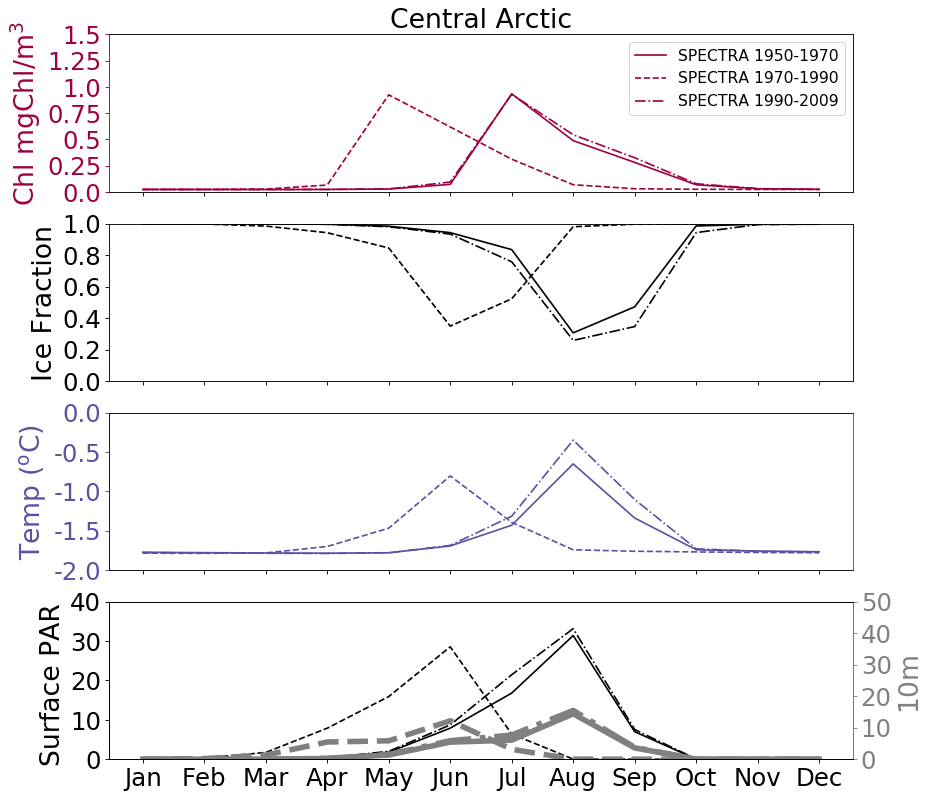

In [33]:
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, (ax,ax2,ax1,ax3) = plt.subplots(nrows=4,
                       ncols=1,
                       sharex=True,
                       sharey=False,
                       figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
#ax.plot(months,obs_ao, '-o', color=cmap(0),linewidth=5,label='SeaWiFS')
ax.plot(months,model_ao_01, '-', color=cmap(0),label='SPECTRA 1950-1970')
ax.plot(months,model_ao_02, '--', color=cmap(0),label='SPECTRA 1970-1990')
ax.plot(months,model_ao_03, '-.', color=cmap(0),label='SPECTRA 1990-2009')
ax1.plot(months,temp_ao_01, '-', color=cmap(9),label='Surface temperature 1st 20 years')
ax1.plot(months,temp_ao_02, '--', color=cmap(9),label='Surface temperature 2nd 20 years')
ax1.plot(months,temp_ao_03, '-.', color=cmap(9),label='Surface temperature 3rd 20 years')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Central Arctic', fontsize=24)

ax2.plot(months, ice_ao_01,'-', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ao_01,'-', color='k',label='PAR Average')
ax2.plot(months, ice_ao_02,'--', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ao_02,'--', color='k',label='PAR Average')
ax2.plot(months, ice_ao_03,'-.', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ao_03,'-.', color='k',label='PAR Average')

ax4 = ax3.twinx();
ax4.plot(months, PAR5_ao_01,'-', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_ao_02,'--', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_ao_03,'-.', linewidth=5,color='gray',label='PAR Average')
ax4.set_ylim(0,50); ax4.set_yticklabels([0,10,20,30,40,50],fontsize=22)
ax4.set_ylabel('10m', fontsize=24);ax4.yaxis.label.set_color('gray')  
ax4.spines['right'].set_color('gray'); ax4.tick_params(axis='y', colors='gray') 
ax3.set_ylim(0,40); ax3.set_yticklabels([0,10,20,30,40,50],fontsize=22)

ax.set_ylim(0,1.5); ax2.set_ylim(0,1);ax1.set_ylim(-2,0)
ax1.set_yticklabels([-2.0,-1.5,-1.0,-0.5,0.0],fontsize=22)
ax.set_yticklabels([0.0,0.25,0.50,0.75,1.0,1.25,1.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(0))  
ax.spines['left'].set_color(cmap(0)); ax.tick_params(axis='y', colors=cmap(0))  

# Axes for temperature 
ax1.set_ylabel('Temp ($^oC$)', fontsize=24); ax1.yaxis.label.set_color(cmap(9))  
ax1.spines['right'].set_color(cmap(9)); ax1.tick_params(axis='y', colors=cmap(9)) 

# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('Surface PAR ', fontsize=24);ax3.yaxis.label.set_color('k')  
ax3.spines['left'].set_color('k'); ax3.tick_params(axis='y', colors='k')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_central_Arctic_Chl_Interdecadal.png', dpi=600, bbox_inches='tight')

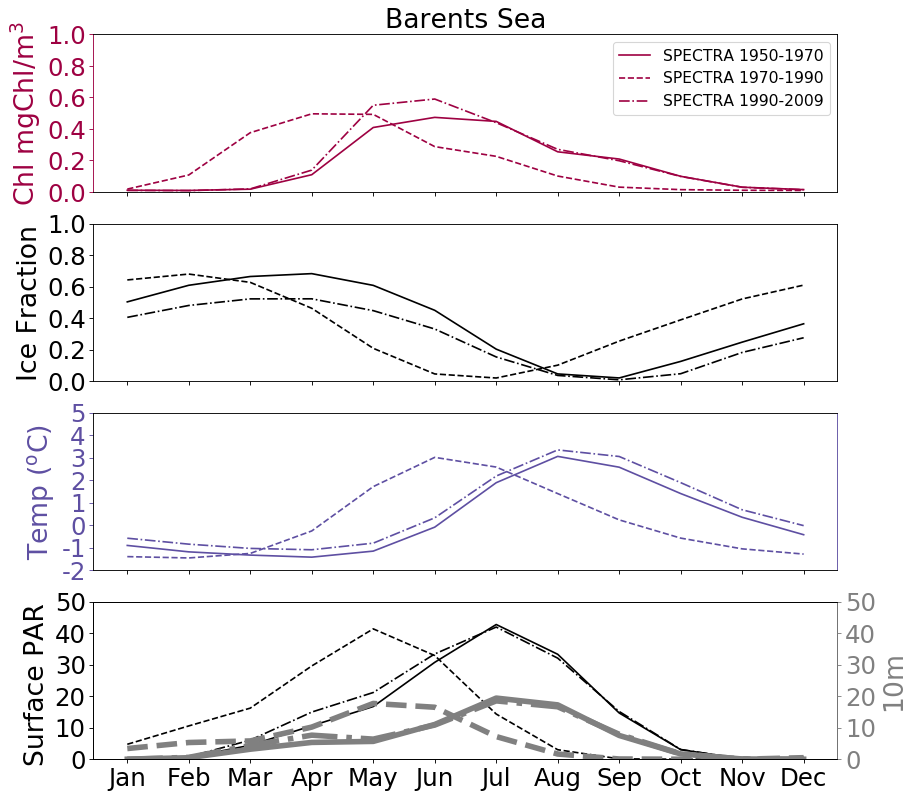

In [35]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, (ax,ax2,ax1,ax3) = plt.subplots(nrows=4,
                       ncols=1,
                       sharex=True,
                       sharey=False,
                       figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
#ax.plot(months,obs_bts, '-o', color=cmap(0),linewidth=4,label='SeaWiFS')
ax.plot(months,model_bts_01, '-', color=cmap(0),label='SPECTRA 1950-1970')
ax.plot(months,model_bts_02, '--', color=cmap(0),label='SPECTRA 1970-1990')
ax.plot(months,model_bts_03, '-.', color=cmap(0),label='SPECTRA 1990-2009')
ax1.plot(months,temp_bts_01, '-', color=cmap(9),label='Surface temperature 1st 20 years')
ax1.plot(months,temp_bts_02, '--', color=cmap(9),label='Surface temperature 2nd 20 years')
ax1.plot(months,temp_bts_03, '-.', color=cmap(9),label='Surface temperature 3rd 20 years')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Barents Sea', fontsize=24)

ax2.plot(months, ice_bts_01,'-', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bts_01,'-', color='k',label='PAR Average')
ax2.plot(months, ice_bts_02,'--', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bts_02,'--', color='k',label='PAR Average')
ax2.plot(months, ice_bts_03,'-.', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bts_03,'-.', color='k',label='PAR Average')

ax4 = ax3.twinx();
ax4.plot(months, PAR5_bts_01,'-', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_bts_02,'--', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_bts_03,'-.', linewidth=5,color='gray',label='PAR Average')
ax4.set_ylim(0,50); ax4.set_yticklabels([0,10,20,30,40,50],fontsize=22)
ax4.set_ylabel('10m', fontsize=24);ax4.yaxis.label.set_color('gray')  
ax4.spines['right'].set_color('gray'); ax4.tick_params(axis='y', colors='gray') 
ax3.set_ylim(0,50); ax3.set_yticklabels([0,10,20,30,40,50],fontsize=22)

ax.set_ylim(0,1); ax2.set_ylim(0,1);ax1.set_ylim(-2,5)
ax1.set_yticklabels([-2,-1,0,1,2,3,4,5],fontsize=22)
ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(0))  
ax.spines['left'].set_color(cmap(0)); ax.tick_params(axis='y', colors=cmap(0))  
# Axes for temperature 
ax1.set_ylabel('Temp ($^oC$)', fontsize=24); ax1.yaxis.label.set_color(cmap(9))  
ax1.spines['right'].set_color(cmap(9)); ax1.tick_params(axis='y', colors=cmap(9)) 
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('Surface PAR ', fontsize=24);ax3.yaxis.label.set_color('k')  
ax3.spines['left'].set_color('k'); ax3.tick_params(axis='y', colors='k')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_Barents_Chl_Interdecadal.png', dpi=600, bbox_inches='tight')

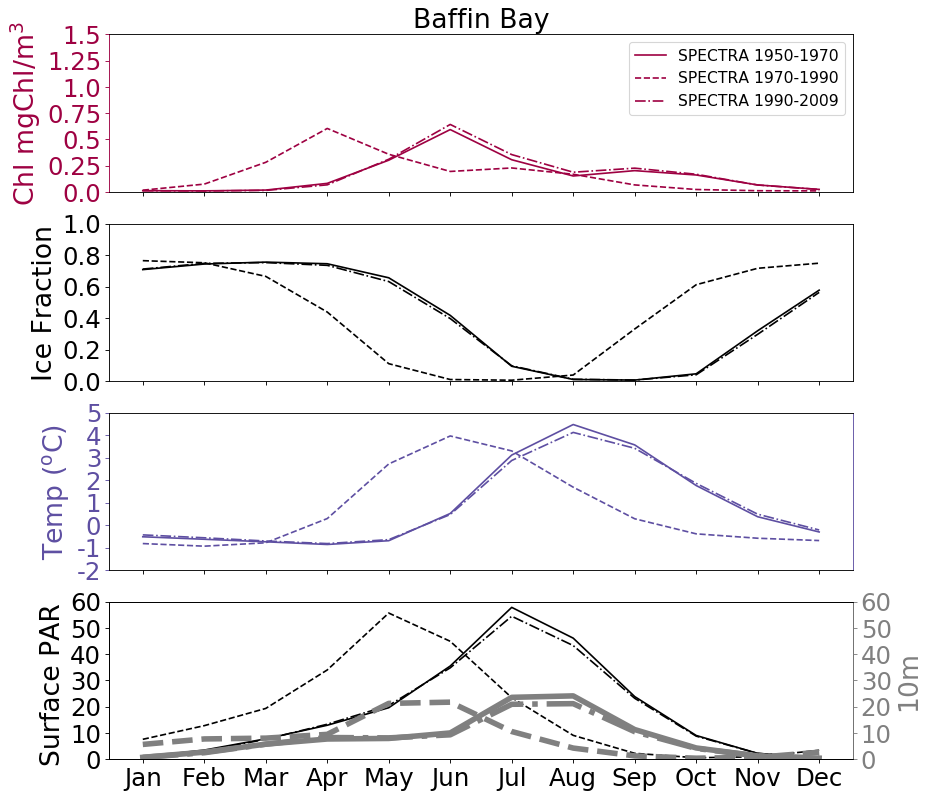

In [36]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, (ax,ax2,ax1,ax3) = plt.subplots(nrows=4,
                       ncols=1,
                       sharex=True,
                       sharey=False,
                       figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
#ax.plot(months,obs_bb, '-o', color=cmap(0),linewidth=4,label='SeaWiFS')
ax.plot(months,model_bb_01, '-', color=cmap(0),label='SPECTRA 1950-1970')
ax.plot(months,model_bb_02, '--', color=cmap(0),label='SPECTRA 1970-1990')
ax.plot(months,model_bb_03, '-.', color=cmap(0),label='SPECTRA 1990-2009')
ax1.plot(months,temp_bb_01, '-', color=cmap(9),label='Surface temperature 1st 20 years')
ax1.plot(months,temp_bb_02, '--', color=cmap(9),label='Surface temperature 2nd 20 years')
ax1.plot(months,temp_bb_03, '-.', color=cmap(9),label='Surface temperature 3rd 20 years')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Baffin Bay', fontsize=24)

ax2.plot(months, ice_bb_01,'-', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bb_01,'-', color='k',label='PAR Average')
ax2.plot(months, ice_bb_02,'--', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bb_02,'--', color='k',label='PAR Average')
ax2.plot(months, ice_bb_03,'-.', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bb_03,'-.', color='k',label='PAR Average')

ax4 = ax3.twinx();
ax4.plot(months, PAR5_bb_01,'-', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_bb_02,'--', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_bb_03,'-.', linewidth=5,color='gray',label='PAR Average')
ax4.set_ylim(0,60); ax4.set_yticklabels([0,10,20,30,40,50,60],fontsize=22)
ax4.set_ylabel('10m', fontsize=24);ax4.yaxis.label.set_color('gray')  
ax4.spines['right'].set_color('gray'); ax4.tick_params(axis='y', colors='gray') 
ax3.set_ylim(0,60); ax3.set_yticklabels([0,10,20,30,40,50,60],fontsize=22)

ax.set_ylim(0,1.5); ax2.set_ylim(0,1);ax1.set_ylim(-2,5)
ax1.set_yticklabels([-2,-1,0,1,2,3,4,5],fontsize=22)
ax.set_yticklabels([0.0,0.25,0.50,0.75,1.0,1.25,1.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(0))  
ax.spines['left'].set_color(cmap(0)); ax.tick_params(axis='y', colors=cmap(0))  
# Axes for temperature 
ax1.set_ylabel('Temp ($^oC$)', fontsize=24); ax1.yaxis.label.set_color(cmap(9))  
ax1.spines['right'].set_color(cmap(9)); ax1.tick_params(axis='y', colors=cmap(9)) 
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('Surface PAR ', fontsize=24);ax3.yaxis.label.set_color('k')  
ax3.spines['left'].set_color('k'); ax3.tick_params(axis='y', colors='k')   
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_Baffin_Chl_Interdecadal.png', dpi=600, bbox_inches='tight')

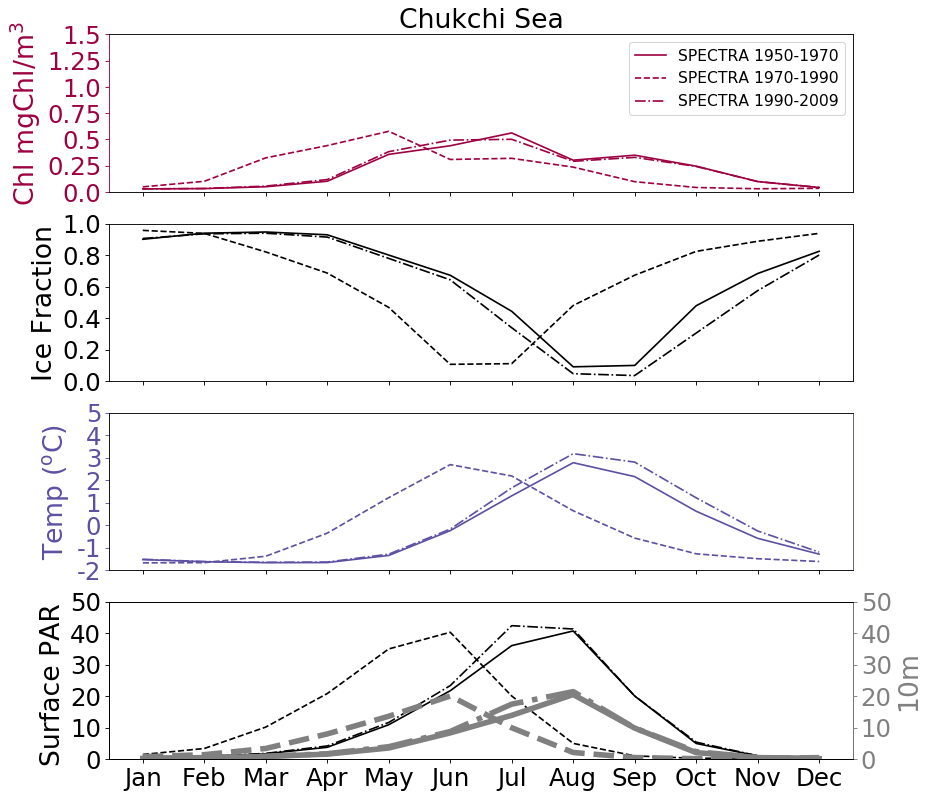

In [37]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, (ax,ax2,ax1,ax3) = plt.subplots(nrows=4,
                       ncols=1,
                       sharex=True,
                       sharey=False,
                       figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
#ax.plot(months,obs_cs, '-o', color=cmap(0),linewidth=4,label='SeaWiFS')
ax.plot(months,model_cs_01, '-', color=cmap(0),label='SPECTRA 1950-1970')
ax.plot(months,model_cs_02, '--', color=cmap(0),label='SPECTRA 1970-1990')
ax.plot(months,model_cs_03, '-.', color=cmap(0),label='SPECTRA 1990-2009')
ax1.plot(months,temp_cs_01, '-', color=cmap(9),label='Surface temperature 1st 20 years')
ax1.plot(months,temp_cs_02, '--', color=cmap(9),label='Surface temperature 2nd 20 years')
ax1.plot(months,temp_cs_03, '-.', color=cmap(9),label='Surface temperature 3rd 20 years')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Chukchi Sea', fontsize=24)

ax2.plot(months, ice_cs_01,'-', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_cs_01,'-', color='k',label='PAR Average')
ax2.plot(months, ice_cs_02,'--', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_cs_02,'--', color='k',label='PAR Average')
ax2.plot(months, ice_cs_03,'-.', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_cs_03,'-.', color='k',label='PAR Average')

ax4 = ax3.twinx();
ax4.plot(months, PAR5_cs_01,'-', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_cs_02,'--', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_cs_03,'-.', linewidth=5,color='gray',label='PAR Average')
ax4.set_ylim(0,50); ax4.set_yticklabels([0,10,20,30,40,50],fontsize=22)
ax4.set_ylabel('10m', fontsize=24);ax4.yaxis.label.set_color('gray')  
ax4.spines['right'].set_color('gray'); ax4.tick_params(axis='y', colors='gray') 
ax3.set_ylim(0,50); ax3.set_yticklabels([0,10,20,30,40,50],fontsize=22)

ax.set_ylim(0,1.5); ax2.set_ylim(0,1);ax1.set_ylim(-2,5)
ax1.set_yticklabels([-2,-1,0,1,2,3,4,5],fontsize=22)
ax.set_yticklabels([0.0,0.25,0.50,0.75,1.0,1.25,1.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(0))  
ax.spines['left'].set_color(cmap(0)); ax.tick_params(axis='y', colors=cmap(0))  
# Axes for temperature 
ax1.set_ylabel('Temp ($^oC$)', fontsize=24); ax1.yaxis.label.set_color(cmap(9))  
ax1.spines['right'].set_color(cmap(9)); ax1.tick_params(axis='y', colors=cmap(9)) 
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('Surface PAR ', fontsize=24);ax3.yaxis.label.set_color('k')  
ax3.spines['left'].set_color('k'); ax3.tick_params(axis='y', colors='k')   
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_Chuckchi_Chl_Interdecadal.png', dpi=600, bbox_inches='tight')

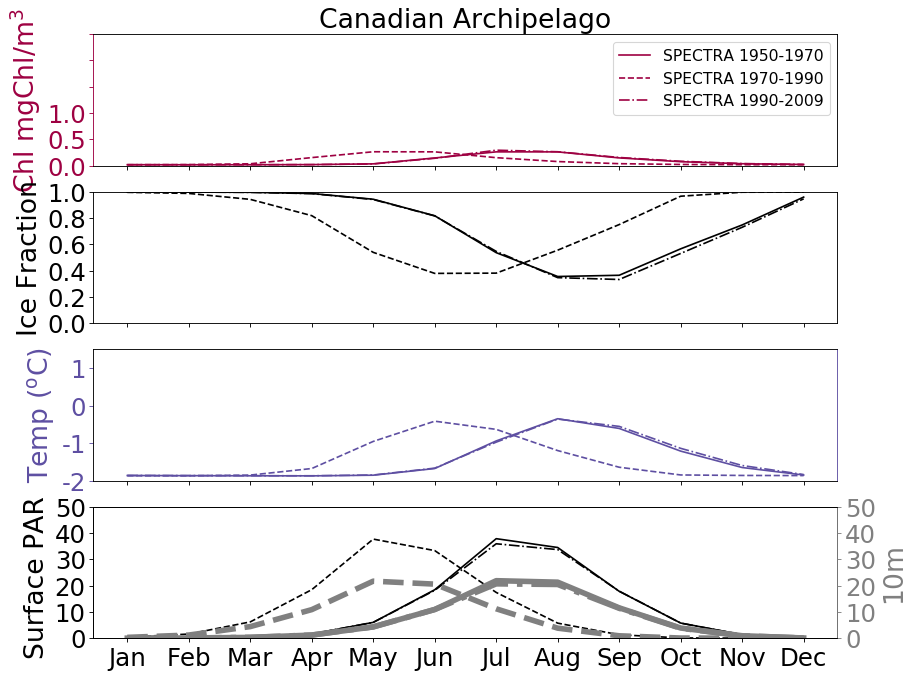

In [27]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, (ax,ax2,ax1,ax3) = plt.subplots(nrows=4,
                       ncols=1,
                       sharex=True,
                       sharey=False,
                       figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
#ax.plot(months,obs_ca, '-o', color=cmap(0),linewidth=4,label='SeaWiFS')
ax.plot(months,model_ca_01, '-', color=cmap(0),label='SPECTRA 1950-1970')
ax.plot(months,model_ca_02, '--', color=cmap(0),label='SPECTRA 1970-1990')
ax.plot(months,model_ca_03, '-.', color=cmap(0),label='SPECTRA 1990-2009')
ax1.plot(months,temp_ca_01, '-', color=cmap(9),label='Surface temperature 1st 20 years')
ax1.plot(months,temp_ca_02, '--', color=cmap(9),label='Surface temperature 2nd 20 years')
ax1.plot(months,temp_ca_03, '-.', color=cmap(9),label='Surface temperature 3rd 20 years')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Canadian Archipelago', fontsize=24)

ax2.plot(months, ice_ca_01,'-', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ca_01,'-', color='k',label='PAR Average')
ax2.plot(months, ice_ca_02,'--', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ca_02,'--', color='k',label='PAR Average')
ax2.plot(months, ice_ca_03,'-.', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ca_03,'-.', color='k',label='PAR Average')

ax4 = ax3.twinx();
ax4.plot(months, PAR5_ca_01,'-', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_ca_02,'--', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_ca_03,'-.', linewidth=5,color='gray',label='PAR Average')
ax4.set_ylim(0,50); ax4.set_yticklabels([0,10,20,30,40,50],fontsize=22)
ax4.set_ylabel('10m', fontsize=24);ax4.yaxis.label.set_color('gray')  
ax4.spines['right'].set_color('gray'); ax4.tick_params(axis='y', colors='gray') 
ax3.set_ylim(0,50); ax3.set_yticklabels([0,10,20,30,40,50],fontsize=22)

ax.set_ylim(0,1); ax2.set_ylim(0,1);ax1.set_ylim(-2,5)
ax1.set_yticklabels([-2,-1,0,1,2,3,4,5],fontsize=22)
ax.set_yticklabels([0.0,0.5,1.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(0))  
ax.spines['left'].set_color(cmap(0)); ax.tick_params(axis='y', colors=cmap(0))  
# Axes for temperature 
ax1.set_ylabel('Temp ($^oC$)', fontsize=24); ax1.yaxis.label.set_color(cmap(9))  
ax1.spines['right'].set_color(cmap(9)); ax1.tick_params(axis='y', colors=cmap(9)) 
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('Surface PAR ', fontsize=24);ax3.yaxis.label.set_color('k')  
ax3.spines['left'].set_color('k'); ax3.tick_params(axis='y', colors='k')   
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_Canada_Chl_Interdecadal.png', dpi=600, bbox_inches='tight')

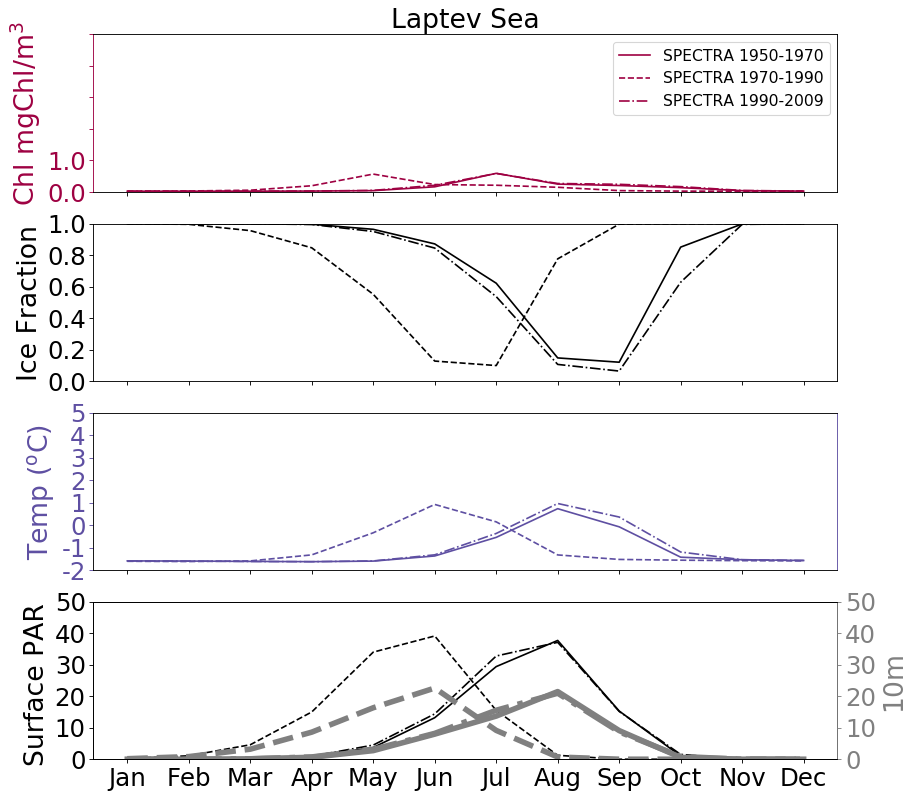

In [28]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, (ax,ax2,ax1,ax3) = plt.subplots(nrows=4,
                       ncols=1,
                       sharex=True,
                       sharey=False,
                       figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
#ax.plot(months,obs_ls, '-o', color=cmap(0),linewidth=4,label='SeaWiFS')
ax.plot(months,model_ls_01, '-', color=cmap(0),label='SPECTRA 1950-1970')
ax.plot(months,model_ls_02, '--', color=cmap(0),label='SPECTRA 1970-1990')
ax.plot(months,model_ls_03, '-.', color=cmap(0),label='SPECTRA 1990-2009')
ax1.plot(months,temp_ls_01, '-', color=cmap(9),label='Surface temperature 1st 20 years')
ax1.plot(months,temp_ls_02, '--', color=cmap(9),label='Surface temperature 2nd 20 years')
ax1.plot(months,temp_ls_03, '-.', color=cmap(9),label='Surface temperature 3rd 20 years')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Laptev Sea', fontsize=24)

ax2.plot(months, ice_ls_01,'-', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ls_01,'-', color='k',label='PAR Average')
ax2.plot(months, ice_ls_02,'--', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ls_02,'--', color='k',label='PAR Average')
ax2.plot(months, ice_ls_03,'-.', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ls_03,'-.', color='k',label='PAR Average')

ax4 = ax3.twinx();
ax4.plot(months, PAR5_ls_01,'-', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_ls_02,'--', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_ls_03,'-.', linewidth=5,color='gray',label='PAR Average')
ax4.set_ylim(0,50); ax4.set_yticklabels([0,10,20,30,40,50],fontsize=22)
ax4.set_ylabel('10m', fontsize=24);ax4.yaxis.label.set_color('gray')  
ax4.spines['right'].set_color('gray'); ax4.tick_params(axis='y', colors='gray') 
ax3.set_ylim(0,50); ax3.set_yticklabels([0,10,20,30,40,50],fontsize=22)

ax.set_ylim(0,1.0); ax2.set_ylim(0,1);ax1.set_ylim(-2,5)
ax1.set_yticklabels([-2,-1,0,1,2,3,4,5],fontsize=22)
ax.set_yticklabels([0.0,1.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(0))  
ax.spines['left'].set_color(cmap(0)); ax.tick_params(axis='y', colors=cmap(0))  
# Axes for temperature 
ax1.set_ylabel('Temp ($^oC$)', fontsize=24); ax1.yaxis.label.set_color(cmap(9))  
ax1.spines['right'].set_color(cmap(9)); ax1.tick_params(axis='y', colors=cmap(9)) 
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('Surface PAR ', fontsize=24);ax3.yaxis.label.set_color('k')  
ax3.spines['left'].set_color('k'); ax3.tick_params(axis='y', colors='k')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_Laptev_Chl_Interdecadal.png', dpi=600, bbox_inches='tight')

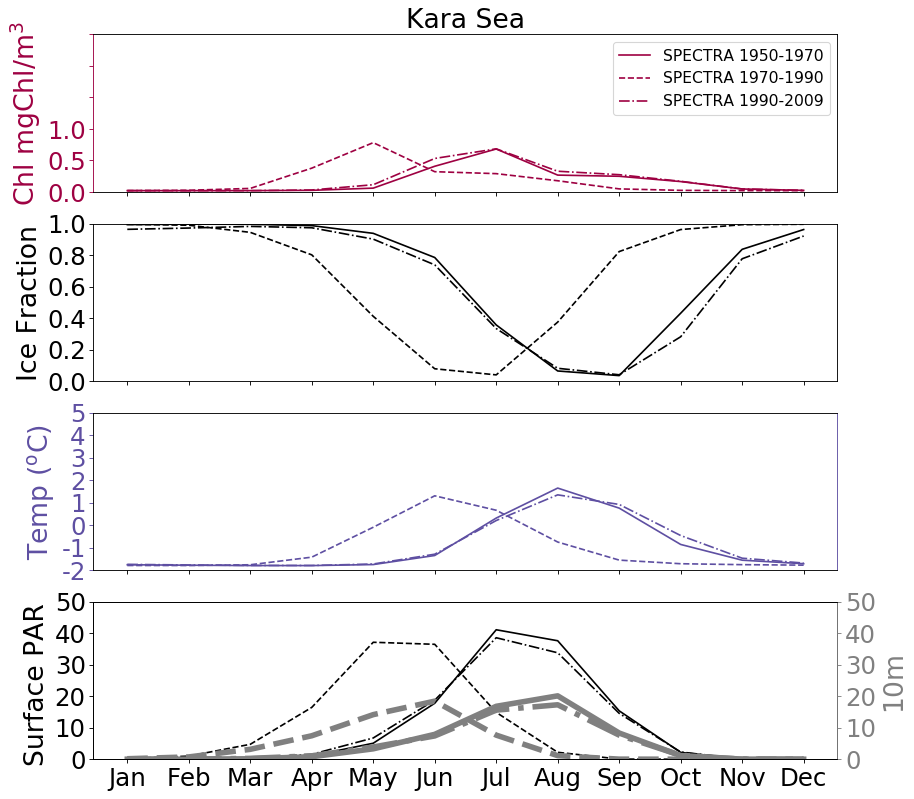

In [29]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, (ax,ax2,ax1,ax3) = plt.subplots(nrows=4,
                       ncols=1,
                       sharex=True,
                       sharey=False,
                       figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
#ax.plot(months,obs_ca, '-o', color=cmap(0),linewidth=4,label='SeaWiFS')
ax.plot(months,model_ks_01, '-', color=cmap(0),label='SPECTRA 1950-1970')
ax.plot(months,model_ks_02, '--', color=cmap(0),label='SPECTRA 1970-1990')
ax.plot(months,model_ks_03, '-.', color=cmap(0),label='SPECTRA 1990-2009')
ax1.plot(months,temp_ks_01, '-', color=cmap(9),label='Surface temperature 1st 20 years')
ax1.plot(months,temp_ks_02, '--', color=cmap(9),label='Surface temperature 2nd 20 years')
ax1.plot(months,temp_ks_03, '-.', color=cmap(9),label='Surface temperature 3rd 20 years')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Kara Sea', fontsize=24)

ax2.plot(months, ice_ks_01,'-', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ks_01,'-', color='k',label='PAR Average')
ax2.plot(months, ice_ks_02,'--', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ks_02,'--', color='k',label='PAR Average')
ax2.plot(months, ice_ks_03,'-.', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ks_03,'-.', color='k',label='PAR Average')

ax4 = ax3.twinx();
ax4.plot(months, PAR5_ks_01,'-', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_ks_02,'--', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_ks_03,'-.', linewidth=5,color='gray',label='PAR Average')
ax4.set_ylim(0,50); ax4.set_yticklabels([0,10,20,30,40,50],fontsize=22)
ax4.set_ylabel('10m', fontsize=24);ax4.yaxis.label.set_color('gray')  
ax4.spines['right'].set_color('gray'); ax4.tick_params(axis='y', colors='gray') 
ax3.set_ylim(0,50); ax3.set_yticklabels([0,10,20,30,40,50],fontsize=22)

ax.set_ylim(0,1); ax2.set_ylim(0,1);ax1.set_ylim(-2,5)
ax1.set_yticklabels([-2,-1,0,1,2,3,4,5],fontsize=22)
ax.set_yticklabels([0.0,0.5,1.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(0))  
ax.spines['left'].set_color(cmap(0)); ax.tick_params(axis='y', colors=cmap(0))
# Axes for temperature 
ax1.set_ylabel('Temp ($^oC$)', fontsize=24); ax1.yaxis.label.set_color(cmap(9))  
ax1.spines['right'].set_color(cmap(9)); ax1.tick_params(axis='y', colors=cmap(9)) 
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('Surface PAR ', fontsize=24);ax3.yaxis.label.set_color('k')  
ax3.spines['left'].set_color('k'); ax3.tick_params(axis='y', colors='k')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_Kara_Chl_Interdecadal.png', dpi=600, bbox_inches='tight')

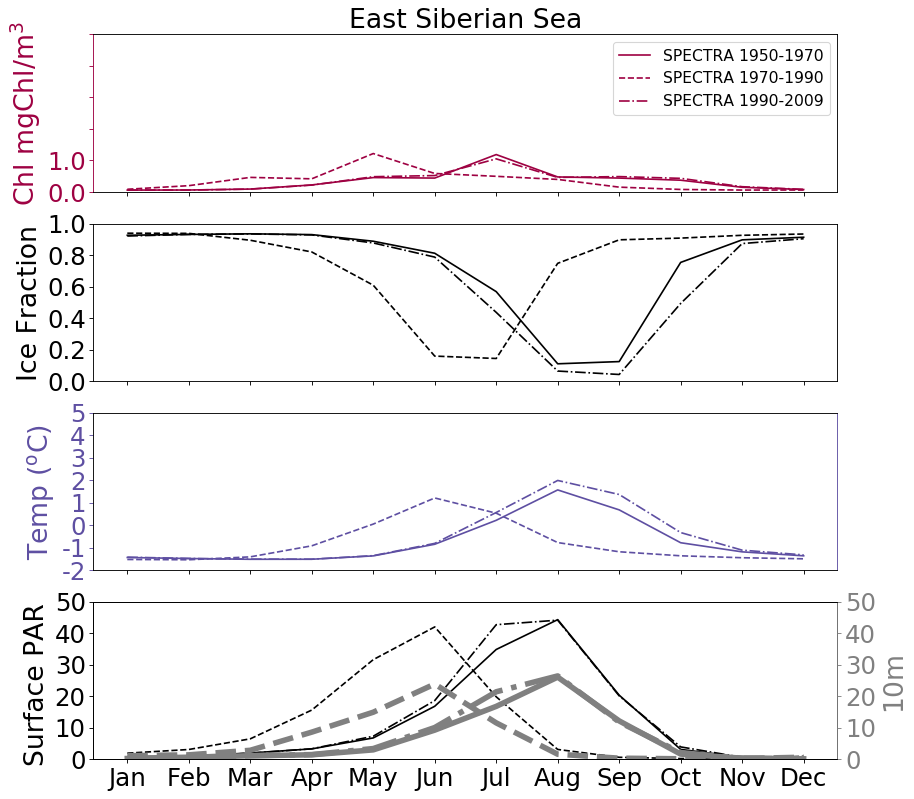

In [30]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, (ax,ax2,ax1,ax3) = plt.subplots(nrows=4,
                       ncols=1,
                       sharex=True,
                       sharey=False,
                       figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
#ax.plot(months,obs_ess, '-o', color=cmap(0),linewidth=4,label='SeaWiFS')
ax.plot(months,model_ess_01, '-', color=cmap(0),label='SPECTRA 1950-1970')
ax.plot(months,model_ess_02, '--', color=cmap(0),label='SPECTRA 1970-1990')
ax.plot(months,model_ess_03, '-.', color=cmap(0),label='SPECTRA 1990-2009')
ax1.plot(months,temp_ess_01, '-', color=cmap(9),label='Surface temperature 1st 20 years')
ax1.plot(months,temp_ess_02, '--', color=cmap(9),label='Surface temperature 2nd 20 years')
ax1.plot(months,temp_ess_03, '-.', color=cmap(9),label='Surface temperature 3rd 20 years')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('East Siberian Sea', fontsize=24)

ax2.plot(months, ice_ess_01,'-', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ess_01,'-', color='k',label='PAR Average')
ax2.plot(months, ice_ess_02,'--', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ess_02,'--', color='k',label='PAR Average')
ax2.plot(months, ice_ess_03,'-.', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ess_03,'-.', color='k',label='PAR Average')

ax4 = ax3.twinx();
ax4.plot(months, PAR5_ess_01,'-', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_ess_02,'--', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_ess_03,'-.', linewidth=5,color='gray',label='PAR Average')
ax4.set_ylim(0,50); ax4.set_yticklabels([0,10,20,30,40,50],fontsize=22)
ax4.set_ylabel('10m', fontsize=24);ax4.yaxis.label.set_color('gray')  
ax4.spines['right'].set_color('gray'); ax4.tick_params(axis='y', colors='gray') 
ax3.set_ylim(0,50); ax3.set_yticklabels([0,10,20,30,40,50],fontsize=22)

ax.set_ylim(0,1.0); ax2.set_ylim(0,1);ax1.set_ylim(-2,5)
ax1.set_yticklabels([-2,-1,0,1,2,3,4,5],fontsize=22)
ax.set_yticklabels([0.0,1.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(0))  
ax.spines['left'].set_color(cmap(0)); ax.tick_params(axis='y', colors=cmap(0))  
# Axes for temperature 
ax1.set_ylabel('Temp ($^oC$)', fontsize=24); ax1.yaxis.label.set_color(cmap(9))  
ax1.spines['right'].set_color(cmap(9)); ax1.tick_params(axis='y', colors=cmap(9)) 
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('Surface PAR ', fontsize=24);ax3.yaxis.label.set_color('k')  
ax3.spines['left'].set_color('k'); ax3.tick_params(axis='y', colors='k')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_EastSiberian_Chl_Interdecadal.png', dpi=600, bbox_inches='tight')

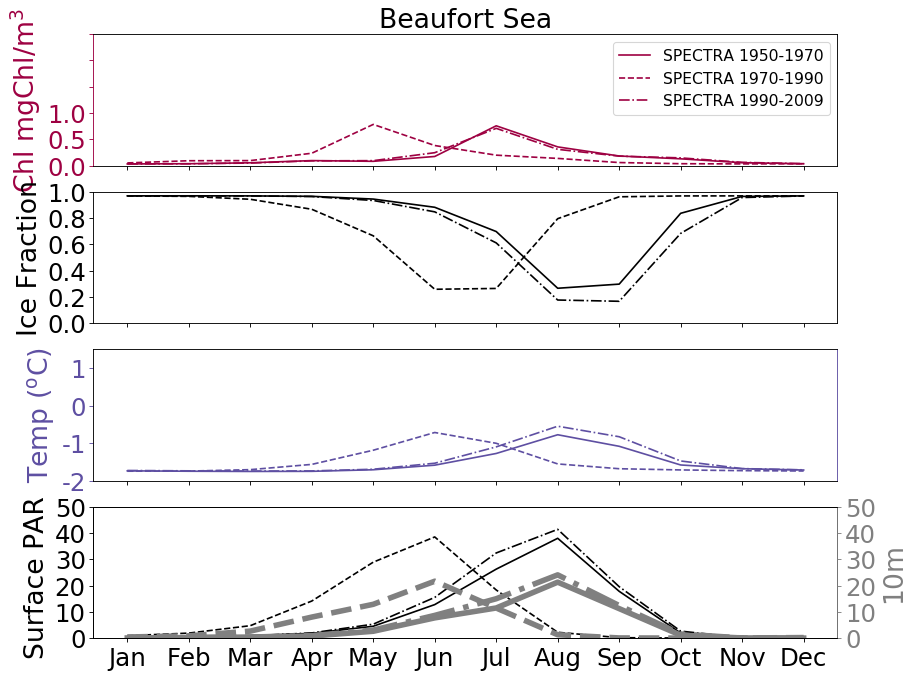

In [31]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, (ax,ax2,ax1,ax3) = plt.subplots(nrows=4,
                       ncols=1,
                       sharex=True,
                       sharey=False,
                       figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
#ax.plot(months,obs_bs, '-o', color=cmap(0),linewidth=4,label='SeaWiFS')
ax.plot(months,model_bs_01, '-', color=cmap(0),label='SPECTRA 1950-1970')
ax.plot(months,model_bs_02, '--', color=cmap(0),label='SPECTRA 1970-1990')
ax.plot(months,model_bs_03, '-.', color=cmap(0),label='SPECTRA 1990-2009')
ax1.plot(months,temp_bs_01, '-', color=cmap(9),label='Surface temperature 1st 20 years')
ax1.plot(months,temp_bs_02, '--', color=cmap(9),label='Surface temperature 2nd 20 years')
ax1.plot(months,temp_bs_03, '-.', color=cmap(9),label='Surface temperature 3rd 20 years')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Beaufort Sea', fontsize=24)

ax2.plot(months, ice_bs_01,'-', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bs_01,'-', color='k',label='PAR Average')
ax2.plot(months, ice_bs_02,'--', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bs_02,'--', color='k',label='PAR Average')
ax2.plot(months, ice_bs_03,'-.', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bs_03,'-.', color='k',label='PAR Average')

ax4 = ax3.twinx();
ax4.plot(months, PAR5_bs_01,'-', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_bs_02,'--', linewidth=5,color='gray',label='PAR Average')
ax4.plot(months, PAR5_bs_03,'-.', linewidth=5,color='gray',label='PAR Average')
ax4.set_ylim(0,50); ax4.set_yticklabels([0,10,20,30,40,50],fontsize=22)
ax4.set_ylabel('10m', fontsize=24);ax4.yaxis.label.set_color('gray')  
ax4.spines['right'].set_color('gray'); ax4.tick_params(axis='y', colors='gray') 
ax3.set_ylim(0,50); ax3.set_yticklabels([0,10,20,30,40,50],fontsize=22)

ax.set_ylim(0,1); ax2.set_ylim(0,1);ax1.set_ylim(-2,5)
ax1.set_yticklabels([-2,-1,0,1,2,3,4,5],fontsize=22)
ax.set_yticklabels([0.0,0.5,1.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(0))  
ax.spines['left'].set_color(cmap(0)); ax.tick_params(axis='y', colors=cmap(0))  
# Axes for temperature 
ax1.set_ylabel('Temp ($^oC$)', fontsize=24); ax1.yaxis.label.set_color(cmap(9))  
ax1.spines['right'].set_color(cmap(9)); ax1.tick_params(axis='y', colors=cmap(9)) 
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('Surface PAR ', fontsize=24);ax3.yaxis.label.set_color('k')  
ax3.spines['left'].set_color('k'); ax3.tick_params(axis='y', colors='k')   
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_Beufort_Chl_Interdecadal.png', dpi=600, bbox_inches='tight')